In [20]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from skimage import exposure

import os
from tqdm import tqdm
import pickle

import imutils
from imutils.contours import sort_contours
from random import randint

In [21]:
def cv2_imshow(img, title='Image', size=None):
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    else:
        img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    if size is not None:
        plt.figure(figsize=size)
    plt.imshow(img)
    plt.title(title)
    plt.show()

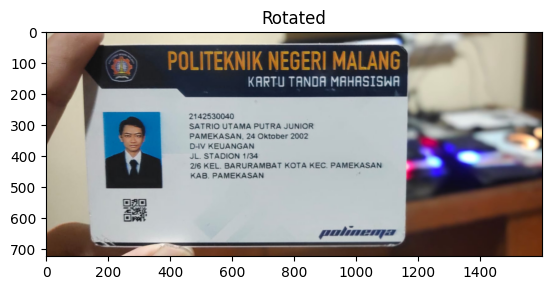

In [22]:
imgKTM = cv.imread('./Kelompok 6/3D_2141720105_5 - SYAIKHUL SHAFWAN R.jpeg')

cv2_imshow(imgKTM, 'Rotated')

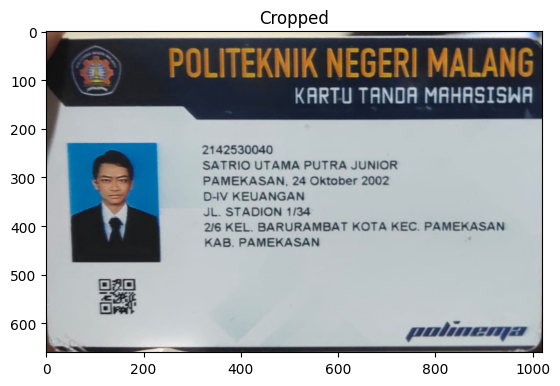

In [23]:
x, y, w, h = 140, 30, 1160, 690
imgKTM = imgKTM[y:h, x:w]
cv2_imshow(imgKTM, 'Cropped')

In [24]:
def reflection(img):
    hsv_image = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv_image)

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v = clahe.apply(v)

    hsv_image = cv.merge([h, s, v])
    return cv.cvtColor(hsv_image, cv.COLOR_HSV2BGR)

In [25]:
# Define function for contour detection
def find_contours(img):
    conts = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    conts = sort_contours(conts, method='left-to-right')[0]

    return conts

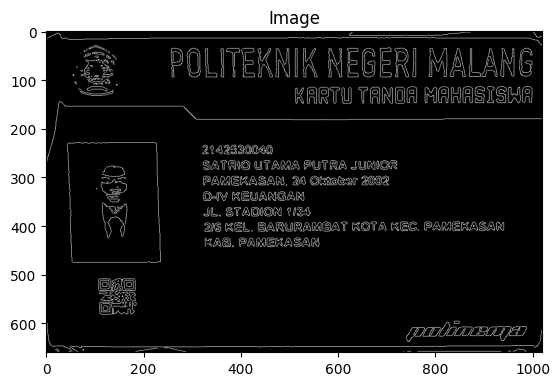

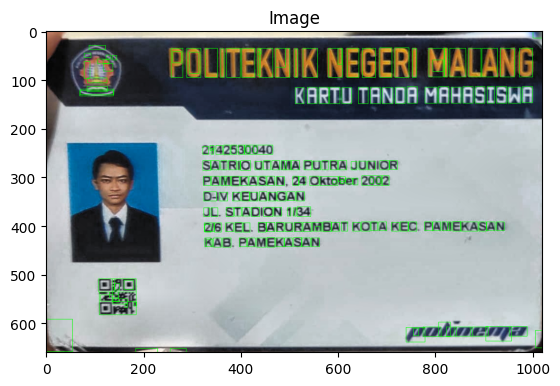

In [26]:
imgKTM = reflection(imgKTM)
# opening
warp = imgKTM.copy()
img_asli = imgKTM.copy()
gray = cv.cvtColor(imgKTM, cv.COLOR_BGR2GRAY)
kernel = np.ones((1,3),np.uint8)
opening = cv.morphologyEx(gray, cv.MORPH_OPEN, kernel)
otsu = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
# otsu = cv.bitwise_not(otsu)

canny = cv.Canny(otsu, 30, 400)
cv2_imshow(canny)

min_w, max_w = 5, 80
min_h, max_h = 8, 90
contours = find_contours(canny.copy())
for c in contours:
    (x, y, w, h) = cv.boundingRect(c)  # find bounding box based on contour
    # if pixel follow this rule, it consider as char
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        cv.rectangle(imgKTM, (x, y), (x + w, y + h), (0, 255, 0), 1)

cv2_imshow(imgKTM)

In [27]:
from keras.models import load_model
model = load_model("alphabet.model")
width, height = 13, 19

alphabet = []
for char_name in sorted(os.listdir("dataset")):
    alphabet.append(char_name)

1/1 [==============================] - 0s 42ms/step


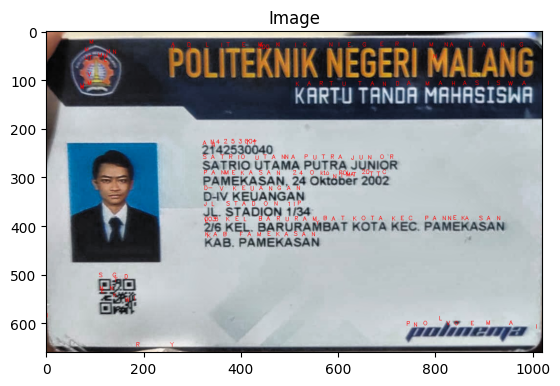

In [28]:
min_w, max_w = 5, 80
min_h, max_h = 8, 90
num = 0
for c in contours:
    (x, y, w, h) = cv.boundingRect(c)  # find bounding box based on contour
    # if pixel follow this rule, it consider as char
    if (w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
        roi = img_asli[y:y+h, x:x+w]  # get region of interest for char
        roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)  # convert to grayscale
        roi = cv.resize(roi, (width, height))
        # thresh = cv.threshold(roi, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
        roi = np.array(roi).reshape(-1, width, height, 1)
        roi = roi / 255.0
        prediction = model.predict(roi)
        cv.putText(warp, alphabet[np.argmax(prediction[0])],
                (x, y - 4), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        num += 1
        # Build bounding box on original image
        # cv.rectangle(warp, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Show bounding box on original image
cv2_imshow(warp)